In [ ]:
%tensorflow_version 1.4.1

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.4.1`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
import os
import pickle
import math
import random
import csv
from PIL import Image

import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
from sklearn.utils import shuffle

print('All modules imported.')

All modules imported.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 1 Reload the preprocessed data

In [ ]:
# 1 Reload the preprocessed data

pickle_file = '/content/gdrive/My Drive/Traffic-Sign-Classifier-master/pre-traffic-signs-data/pre-data.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    X_train = pickle_data['train_features']
    y_train = pickle_data['train_labels']
    X_valid = pickle_data['valid_features']
    y_valid = pickle_data['valid_labels']
    X_test = pickle_data['test_features']
    y_test = pickle_data['test_labels']
    signnames = pickle_data['signnames']
    del pickle_data  # Free up memory
    
# Shuffle the data set
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)
print(len(signnames))
print('Data loaded.')

(34799, 32, 32, 3) (34799,)
(4410, 32, 32, 3) (4410,)
(12630, 32, 32, 3) (12630,)
43
Data loaded.


# 2 Model Architecture

## 2.1 Inception model and GoogLeNet

In [ ]:
def Inception(inputs, conv11_size, conv33_11_size, conv33_size,conv55_11_size, conv55_size, pool11_size):
    conv11 = layers.conv2d(inputs, conv11_size, [1, 1])
    conv33_reduce = layers.conv2d(inputs, conv33_11_size, [1, 1])
    conv33 = layers.conv2d(conv33_reduce, conv33_size, [3, 3])
    conv55_reduce = layers.conv2d(inputs, conv55_11_size, [1, 1])
    conv55 = layers.conv2d(conv55_reduce, conv55_size, [5, 5])
    pool_proj = layers.max_pool2d(inputs, [3, 3], stride = 1, padding='SAME')
    pool11 = layers.conv2d(pool_proj, pool11_size, [1, 1])
    return tf.concat([conv11, conv33, conv55, pool11], 3)

def GoogLeNet(inputs, dropout_keep_prob): # inputs size:32x32x3
    conv1 = layers.conv2d(inputs, 64, [3, 3], stride = 2) # 16x16x64
    
    inception_2a = Inception(conv1, 64, 96, 128, 16, 32, 32) # 16x16x256
    inception_2b = Inception(inception_2a, 128, 128, 192, 32, 96, 64) # 16x16x480
    pool2 = layers.max_pool2d(inception_2b, [3, 3]) # 7x7x480 ? why
    
    inception_3a = Inception(pool2, 192, 96, 208, 16, 48, 64) # 7x7x512
    inception_3b = Inception(inception_3a, 160, 112, 224, 24, 64, 64) # 7x7x512
    pool3 = layers.max_pool2d(inception_3b, [3, 3]) # 3x3x512
    
    inception_4a = Inception(pool3, 256, 160, 320, 32, 128, 128) # 3x3x832
    inception_4b = Inception(inception_4a, 384, 192, 384, 48, 128, 128) # 3x3x1024
    pool4 = layers.avg_pool2d(inception_4b, [3, 3], stride = 1) 

    reshape = tf.reshape(pool4, [-1, 1024])
    dropout = layers.dropout(reshape, dropout_keep_prob)
    logits = layers.fully_connected(dropout, 43, activation_fn=None)
    
    return logits

# 3 Training

## 3.1 Strategy

In [ ]:
# Placeholder
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder_with_default(1.0, shape=())

# Hyperparameters
LEARNING_RATE = 0.0005
EPOCHS = 50
BATCH_SIZE = 128

# Train method
logits = GoogLeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_op = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
train_op = optimizer.minimize(loss_op)

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## 3.2 Evaluation

In [ ]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
#     with tf.Session() as sess:
#         sess.run(tf.global_variables_initializer())
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy, loss = sess.run([accuracy_op,loss_op], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples, loss

## 3.3 Train the Model
A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [ ]:
%%time
saver = tf.train.Saver()
train_accuracy = []
valid_accuracy = []
learning_rates = []
train_losses = []
valid_losses = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        total_train_acc = 0
        print("EPOCH {} :".format(i+1), end=' ')
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, train_loss = sess.run([train_op, loss_op], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            _, train_acc = sess.run([train_op, accuracy_op], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            total_train_acc += (train_acc * len(batch_x))
            train_losses.append(train_loss)
        train_accuracy.append(total_train_acc / num_examples)
        valid_acc, valid_loss = evaluate(X_valid, y_valid)
        valid_accuracy.append(valid_acc)
        print("Validation Accuracy = {:.3f}".format(valid_acc))
        valid_losses.append(valid_loss)
        
    saver.save(sess, '/content/gdrive/My Drive/Traffic-Sign-Classifier-master/model/googlenet.ckpt')
    print("Model saved")

Training...
EPOCH 1 : Validation Accuracy = 0.865
EPOCH 2 : Validation Accuracy = 0.931
EPOCH 3 : Validation Accuracy = 0.949
EPOCH 4 : Validation Accuracy = 0.937
EPOCH 5 : Validation Accuracy = 0.976
EPOCH 6 : Validation Accuracy = 0.965
EPOCH 7 : Validation Accuracy = 0.956
EPOCH 8 : Validation Accuracy = 0.967
EPOCH 9 : Validation Accuracy = 0.944
EPOCH 10 : Validation Accuracy = 0.973
EPOCH 11 : Validation Accuracy = 0.960
EPOCH 12 : Validation Accuracy = 0.973
EPOCH 13 : Validation Accuracy = 0.973
EPOCH 14 : Validation Accuracy = 0.967
EPOCH 15 : Validation Accuracy = 0.984
EPOCH 16 : Validation Accuracy = 0.977
EPOCH 17 : Validation Accuracy = 0.968
EPOCH 18 : Validation Accuracy = 0.983
EPOCH 19 : Validation Accuracy = 0.984
EPOCH 20 : Validation Accuracy = 0.975
EPOCH 21 : Validation Accuracy = 0.970
EPOCH 22 : Validation Accuracy = 0.982
EPOCH 23 : Validation Accuracy = 0.977
EPOCH 24 : Validation Accuracy = 0.978
EPOCH 25 : Validation Accuracy = 0.969
EPOCH 26 : Validation 

#### Plot the accuracy of training and validation operation

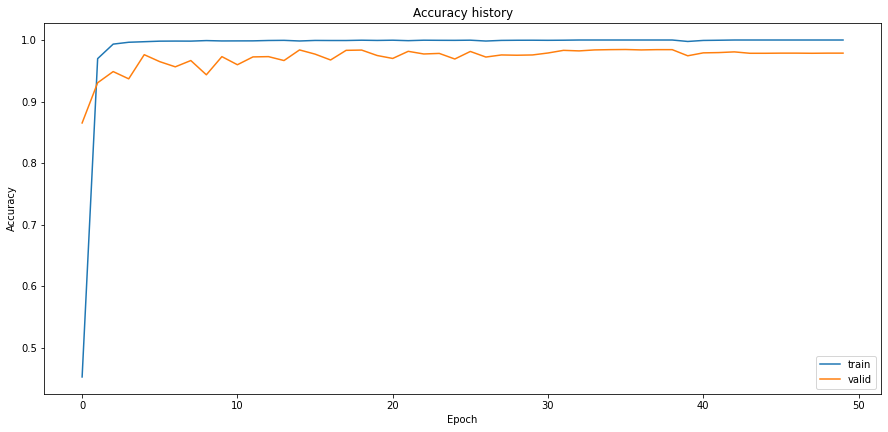

In [ ]:
plt.subplot(2, 1, 2)
plt.plot(train_accuracy, label='train')
plt.plot(valid_accuracy, label='valid')
plt.title('Accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.gcf().set_size_inches(15, 15)
plt.legend()
plt.savefig('/content/gdrive/My Drive/Traffic-Sign-Classifier-master/result_images/GoogLeNet_acc.png')
plt.show()

In [ ]:
plt.subplot(2, 1, 2)
plt.plot(train_losses, label='train_loss')
plt.plot([(i+1) * int(num_examples / BATCH_SIZE) for i in range(EPOCHS)], valid_losses, label='val_loss')
plt.title('Loss History')

plt.ylabel('Loss')
plt.gcf().set_size_inches(15, 12)
plt.legend()
plt.savefig('/content/gdrive/My Drive/Traffic-Sign-Classifier-master/result_images/GoogLeNet_loss.png')
plt.show()

NameError: ignored

# 4 Testing

## 4.1 Test the model on testing dataset

In [ ]:
saver = tf.train.import_meta_graph('/content/gdrive/My Drive/Traffic-Sign-Classifier-master/model/googlenet.ckpt.meta')
with tf.Session() as sess:
    saver.restore(sess, '/content/gdrive/My Drive/Traffic-Sign-Classifier-master/model/googlenet.ckpt')

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Traffic-Sign-Classifier-master/model/googlenet.ckpt


In [ ]:
def evaluate_compare(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
#     with tf.Session() as sess:
#         sess.run(tf.global_variables_initializer())
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy, loss = sess.run([accuracy_op,loss_op], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    saver.restore(sess, '/content/gdrive/My Drive/Traffic-Sign-Classifier-master/model/googlenet.ckpt')
#     sess.run(tf.global_variables_initializer())
    train_accuracy = evaluate_compare(X_train, y_train)
    valid_accuracy = evaluate_compare(X_valid, y_valid)
    test_accuracy = evaluate_compare(X_test, y_test)
    
accuracys = [train_accuracy, valid_accuracy, test_accuracy]
tick_labels = ["training set", "validation set", "testing set"]
plt.bar(range(3), accuracys)
plt.xlabel('data set')
plt.ylabel('accuracy')
plt.xticks(range(3), tick_labels)
for x_,y_ in zip(range(3), accuracys):
    plt.text(x_ - 0.1, y_, '%.3f'%y_)
plt.savefig('/content/gdrive/My Drive/Traffic-Sign-Classifier-master/result_images/GoogLeNet_cf.png')
plt.show()

NameError: ignored

## 4.2 Test the Model on New Images

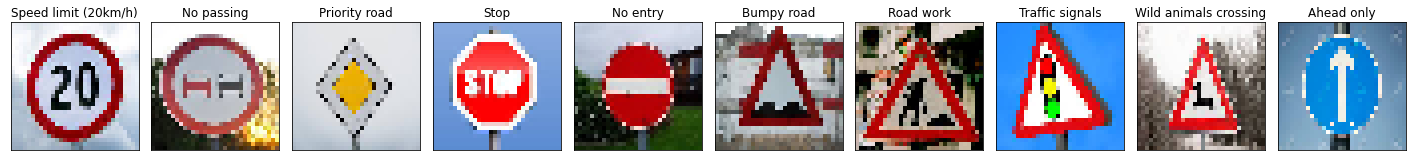

In [ ]:
online_images = []
online_labels = [0, 9, 12, 14, 17, 22, 25, 26, 31, 35]

for i in range(1, 11):
    image = plt.imread('/content/gdrive/My Drive/Traffic-Sign-Classifier-master/test_images/' + str(i) +'.jpeg')
    image_reshape = cv2.resize(image,(32, 32), interpolation = cv2.INTER_CUBIC)
    online_images.append(image_reshape)

plt.figure(figsize=(25, 10))
plt.subplots_adjust(hspace = .1, wspace=.1)
for i in range(len(online_images)):
    plt.subplot(1, 10, i + 1)
    plt.imshow(online_images[i])
    plt.title(signnames[int(online_labels[i])])
    plt.xticks([]), plt.yticks([])
plt.savefig('/content/gdrive/My Drive/Traffic-Sign-Classifier-master/result_images/GoogLeNet_online image.jpg')

online_images = np.array(online_images)
online_images = online_images.astype(np.float32) / 128. - 1.
online_labels = np.array(online_labels)

### Predict the Sign Type for Each Image

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, '/content/gdrive/My Drive/Traffic-Sign-Classifier-master/model/googlenet.ckpt')
    test_accuracy = evaluate(online_images, online_labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))   
    logits_value = sess.run(logits, feed_dict={x: online_images})
    probabilities = sess.run(tf.nn.softmax(logits_value))
    
predict = probabilities.argmax(axis=1)
print("Predict the Sign Type for Each Image")
print(predict)

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Traffic-Sign-Classifier-master/model/googlenet.ckpt


TypeError: ignored

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
with tf.Session() as sess:
    top5 = sess.run(tf.nn.top_k(tf.constant(probabilities), k=5))

values = top5.values
indices = top5.indices
fig, axes = plt.subplots(2, 5, figsize=(25, 8))
for i in range(2):
    for j in range(5):
        axes[i][j].bar(range(5), values[i*5+j])
        axes[i][j].set_xticklabels(indices[i*5+j])
        axes[i][j].set_title("answer: "+str(online_labels[i*5+j]))
        for x_,y_ in zip(range(5), values[i*5+j]):
            axes[i][j].text(x_ - 0.25, y_, '%.3f'%y_)

### Output Confusion Matrix

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, '/content/gdrive/My Drive/Traffic-Sign-Classifier-master/model/googlenet.ckpt')
    test_accuracy = evaluate(X_test, y_test)
    logits_value = sess.run(logits, feed_dict={x: X_test})
    probabilities = sess.run(tf.nn.softmax(logits_value))
    
predict = probabilities.argmax(axis=1)
pd.crosstab(y_test, predict, rownames = ['label'], colnames = ['predict'])

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Traffic-Sign-Classifier-master/model/googlenet.ckpt
